In [36]:
#__autho__:Ziman Z
#__date__:Apr30
# this notebook group the census tract based on the proportion of complaint counts by each hour of the day
# please refer corresponding cells and copy paste to the head of your notebook to avoid redundant data cleaning!

import pandas as pd
import numpy as np
import os
import seaborn

from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.hierarchy import fcluster   # flat cluster

import matplotlib.pyplot as plt
import geopandas as gpd
import shapely
import geojson
import fiona
%pylab inline
cwd = os.getcwd()

output_path = os.path.join(os.path.dirname(cwd), 'output')
data_path = os.path.join(os.path.dirname(cwd), 'data')

Populating the interactive namespace from numpy and matplotlib


In [3]:
file_name = ['reduce_year_ct.txt', 'reduce_month_ct.txt', 'reduce_hour_ct.txt', 'reduce_ct.txt', 'reduce_day_ct.txt']

In [5]:
df_hour = pd.read_csv('../output/hour_data.csv')

In [8]:
(df_hour.BoroCT2010 == df_hour.ct).unique()

array([True], dtype=object)

In [10]:
df_hour = df_hour.ix[:, -4:]

In [11]:
df_hour.shape

(49635, 4)

In [15]:
## Create hour--ct 
df_hour2 = df_hour.iloc[:, :-1]

In [25]:
df_hour2.head(3)

,counts,ct,hour
0,15.0,2002701,13.0
1,23.0,2002701,3.0
2,14.0,2002701,10.0


In [23]:
## get counts proportions in each hour
#pd.DataFrame(df_hour.groupby(['ct','hour'])['counts'].sum())

In [26]:
## create pivot table for counts per hour per census tract
hour_counts = df_hour2.pivot(index='ct', columns='hour', values='counts').fillna(0)

In [50]:
hour_counts.head(5)

hour,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,...,14.0,15.0,16.0,17.0,18.0,19.0,20.0,21.0,22.0,23.0
ct,,,,,,,,,,,,,,,,,,,,,
1000201,107.0,77.0,51.0,34.0,27.0,7.0,4.0,7.0,4.0,8.0,...,12.0,14.0,12.0,14.0,13.0,46.0,33.0,54.0,67.0,85.0
1000202,225.0,174.0,113.0,80.0,43.0,42.0,35.0,29.0,49.0,78.0,...,68.0,54.0,67.0,73.0,76.0,103.0,150.0,155.0,187.0,278.0
1000600,175.0,153.0,65.0,44.0,38.0,27.0,28.0,43.0,64.0,65.0,...,40.0,29.0,40.0,40.0,40.0,67.0,78.0,98.0,138.0,188.0
1000700,284.0,167.0,105.0,54.0,52.0,42.0,75.0,121.0,188.0,143.0,...,145.0,85.0,53.0,56.0,59.0,118.0,238.0,372.0,511.0,532.0
1000800,200.0,150.0,75.0,58.0,25.0,17.0,15.0,15.0,41.0,34.0,...,33.0,21.0,35.0,23.0,38.0,38.0,47.0,70.0,109.0,267.0


In [51]:
## Compute proportion of each hourly count -- total porportions of all hours per CT adds up to 1
hour_prop = hour_counts.apply(lambda row: [r/row.sum() for r in row],axis=1)

# hour_prop.head(3)

In [53]:
hour_prop.iloc[0, :].sum()  ## each row adds up to 1

1.0

In [55]:
hour_columns = ['hour_{}'.format(h) for h in range(24)]

## Change name of columns:
hour_prop = hour_prop.rename(columns=lambda h: 'hour_{}'.format(int(h)))
hour_prop.head(3)

hour,hour_0,hour_1,hour_2,hour_3,hour_4,hour_5,hour_6,hour_7,hour_8,hour_9,...,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23
ct,,,,,,,,,,,,,,,,,,,,,
1000201,0.147586,0.106207,0.070345,0.046897,0.037241,0.009655,0.005517,0.009655,0.005517,0.011034,...,0.016552,0.019310,0.016552,0.019310,0.017931,0.063448,0.045517,0.074483,0.092414,0.117241
1000202,0.099382,0.076855,0.049912,0.035336,0.018993,0.018551,0.015459,0.012809,0.021643,0.034452,...,0.030035,0.023852,0.029594,0.032244,0.033569,0.045495,0.066254,0.068463,0.082597,0.122792
1000600,0.107626,0.094096,0.039975,0.027060,0.023370,0.016605,0.017220,0.026445,0.039360,0.039975,...,0.024600,0.017835,0.024600,0.024600,0.024600,0.041205,0.047970,0.060271,0.084871,0.115621


## Clustering
### Kmeans, Hierarchical

For oberservation purposes, we decide to use 3 clusters for each method

### Kmeans

In [153]:
##### Kmeans clustering -- k=3

k = 3  # number of clusters
X = hour_prop.ix[:, hour_columns] # hour of day data
#tar = hour_prop[''] # real target -- crime_type

#train the model.
km=KMeans(n_clusters=k, random_state=22)
res=km.fit(X)
#result.
print(res.labels_)

# append to the dataframe
hour_prop['label_km'] = res.labels_

[0 0 0 ..., 1 2 2]


### Hierarchical

In [154]:
##### Hirarchical Clustering --k=8
h=8
Z = linkage(X, 'complete')

# Fcluster
hir_res_labels = fcluster(Z, h, criterion='maxclust')
hir_res_labels

# append to the dataframe
hour_prop['label_hier'] = hir_res_labels

In [155]:
hour_prop.head(4)

hour,hour_0,hour_1,hour_2,hour_3,hour_4,hour_5,hour_6,hour_7,hour_8,hour_9,...,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23,label_km,label_hier
ct,,,,,,,,,,,,,,,,,,,,,
1000201,0.147586,0.106207,0.070345,0.046897,0.037241,0.009655,0.005517,0.009655,0.005517,0.011034,...,0.016552,0.019310,0.017931,0.063448,0.045517,0.074483,0.092414,0.117241,0,6
1000202,0.099382,0.076855,0.049912,0.035336,0.018993,0.018551,0.015459,0.012809,0.021643,0.034452,...,0.029594,0.032244,0.033569,0.045495,0.066254,0.068463,0.082597,0.122792,0,5
1000600,0.107626,0.094096,0.039975,0.027060,0.023370,0.016605,0.017220,0.026445,0.039360,0.039975,...,0.024600,0.024600,0.024600,0.041205,0.047970,0.060271,0.084871,0.115621,0,6
1000700,0.072970,0.042909,0.026978,0.013875,0.013361,0.010791,0.019270,0.031089,0.048304,0.036742,...,0.013618,0.014388,0.015159,0.030319,0.061151,0.095581,0.131295,0.136691,2,5


## Hourly Treads based Clusters

In [156]:
# mean for each km cluster
df_clusMeans_km = hour_prop.ix[:, hour_columns + ['label_km']].groupby('label_km').mean()

# mean for each hir cluster
df_clusMeans_hier = hour_prop.ix[:, hour_columns + ['label_hier']].groupby('label_hier').mean()

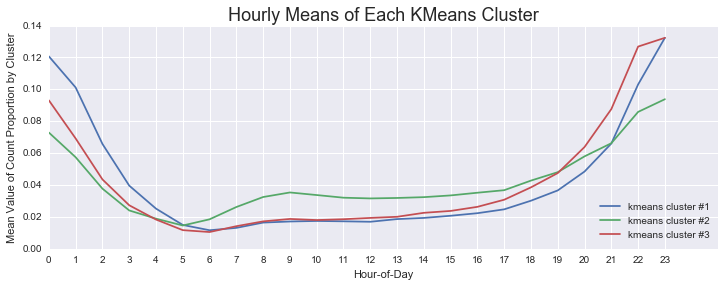

In [157]:
### create a line graph to visualize these values by cluster.
# line graph of this kmeans cluster
plt.figure(figsize=(12,4))

for i in range(k):
    plt.plot(range(len(hour_columns)), df_clusMeans_km.iloc[i,:], label='kmeans cluster #{}'.format(i+1))

plt.title('Hourly Means of Each KMeans Cluster', size=18)
plt.xticks(range(24), range(24))
plt.xlabel('Hour-of-Day')
plt.ylabel('Mean Value of Count Proportion by Cluster')
plt.legend(loc='best')

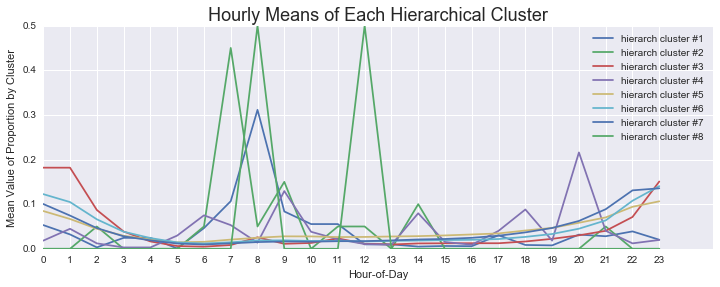

In [158]:
# line graph of this hirarchical clusters
plt.figure(figsize=(12,4))

for i in range(h):
    plt.plot(range(len(hour_columns)), df_clusMeans_hier.iloc[i,:], label='hierarch cluster #{}'.format(i+1))

plt.title('Hourly Means of Each Hierarchical Cluster', size=18)
plt.xticks(range(24), range(24))
plt.xlabel('Hour-of-Day')
plt.ylabel('Mean Value of Proportion by Cluster')
plt.legend(loc='best')

## Visualize the Hour-of-Day Clustering Results on Map

In [159]:
# load shape file with demographic info
nyc_info_shape = gpd.GeoDataFrame.from_file("../output/merged_features_shapefile")

In [160]:
nyc_info_shape.head(3)

,AssessTot,BldgAge,BldgDepthb,BoroCT2010,ComArea,NumBldgs,NumFloors,allother_r,asian_pop,black_pop,comps_perp,counts,elderly_po,female_pop,geometry,hisplat_po,median_hh_,tworaces_p,white_pop
0,1.272389e+05,80.536313,1028.054570,5000900.0,0.315911,1.198324,2.353380,0.073656,0.032796,0.263441,0.226344,421.0,0.059140,0.484946,"POLYGON ((962269.1260375977 173705.5001831055,...",0.136022,28.225806,0.020430,0.124194
1,3.398692e+06,96.623794,2341.444145,1009800.0,0.393859,1.106109,6.585209,0.009146,0.131043,0.016854,0.367651,2814.0,0.182519,0.508231,"POLYGON ((994133.507019043 214848.8975830078, ...",0.028351,15.982623,0.011759,0.670368
2,3.480757e+07,74.400000,6497.351916,1010000.0,0.917437,1.012500,14.668750,0.032680,0.066548,0.010101,0.516934,870.0,0.146762,0.557932,"POLYGON ((993108.3057861328 216013.1307983398,...",0.096257,66.606061,0.013666,0.686275


In [161]:
## Merge cluster labels in to the shapefile
nyc_clus_info_shape = pd.merge(nyc_info_shape, hour_prop, left_on='BoroCT2010', right_index=True)

In [162]:
nyc_clus_info_shape.head(3)

,AssessTot,BldgAge,BldgDepthb,BoroCT2010,ComArea,NumBldgs,NumFloors,allother_r,asian_pop,black_pop,...,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23,label_km,label_hier
0,1.272389e+05,80.536313,1028.054570,5000900.0,0.315911,1.198324,2.353380,0.073656,0.032796,0.263441,...,0.028504,0.040380,0.054632,0.038005,0.054632,0.071259,0.140143,0.140143,2,7
1,3.398692e+06,96.623794,2341.444145,1009800.0,0.393859,1.106109,6.585209,0.009146,0.131043,0.016854,...,0.018479,0.015636,0.021677,0.021322,0.050462,0.074271,0.105899,0.142502,2,5
2,3.480757e+07,74.400000,6497.351916,1010000.0,0.917437,1.012500,14.668750,0.032680,0.066548,0.010101,...,0.024138,0.018391,0.028736,0.024138,0.037931,0.067816,0.062069,0.108046,1,5


<function matplotlib.pyplot.tight_layout>

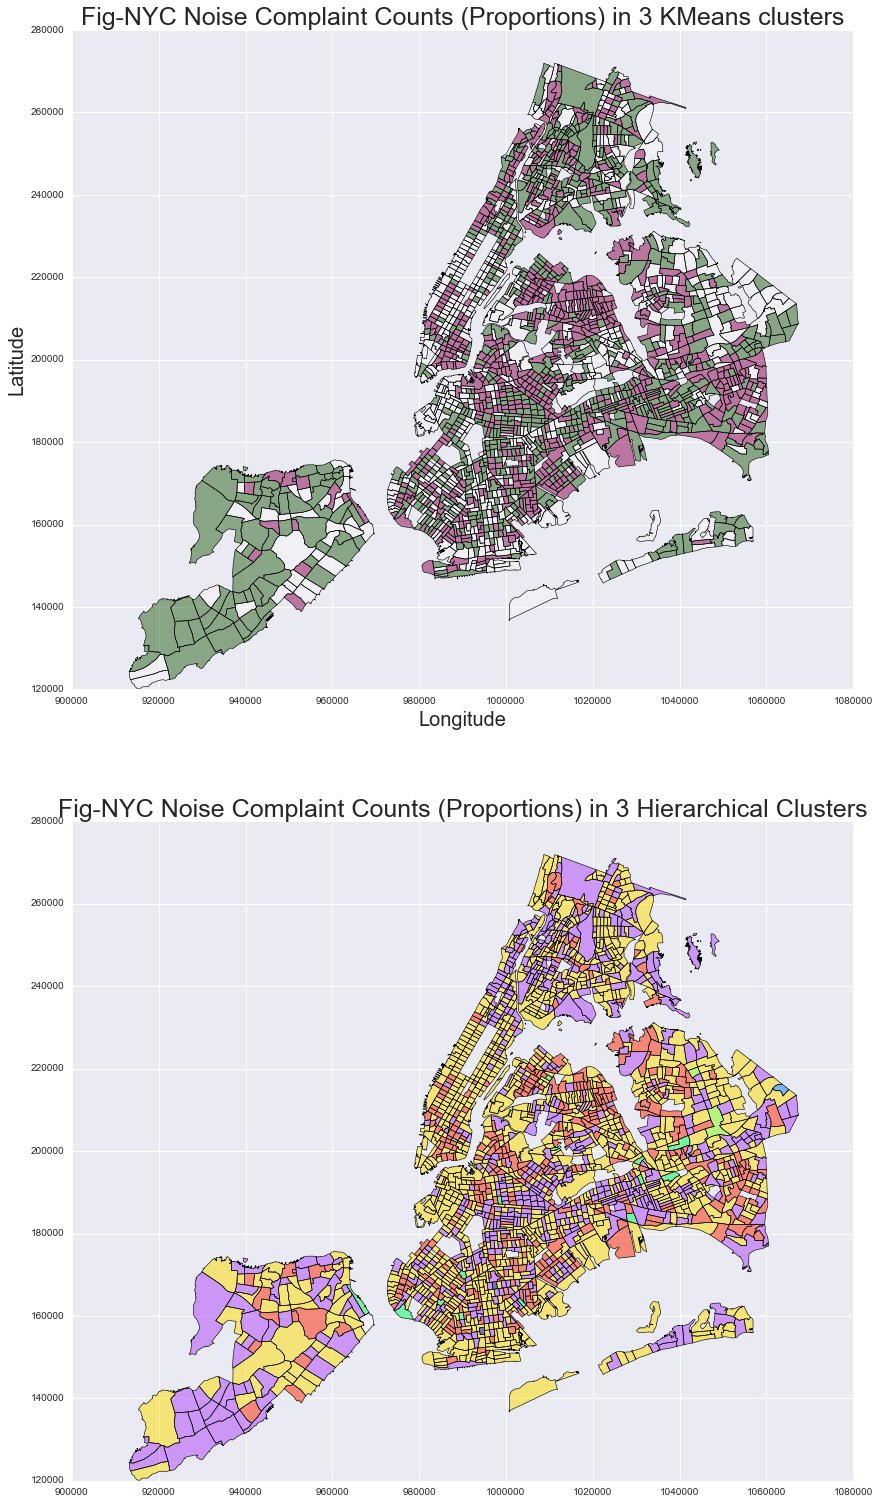

In [175]:
# Plot the maps
fig = plt.figure(figsize(14, 26))

# plot kmeans clusters on map 
ax1 = fig.add_subplot(211)
nyc_clus_info_shape.plot(cmap='PiYG', column='label_km', ax=ax1, categorical=True, k=3, linewidth=0.6)
ax1.set_title('Fig-NYC Noise Complaint Counts (Proportions) in 3 KMeans clusters', fontsize=25)
ax1.set_ylabel('Latitude', size=20)
ax1.set_xlabel('Longitude', size=20)


# plot Hierarchical clusters on map
ax2 = fig.add_subplot(212)
nyc_clus_info_shape.plot(cmap='gist_ncar', column='label_hier', ax=ax2, categorical=True, k=3, linewidth=0.6)
ax2.set_title('Fig-NYC Noise Complaint Counts (Proportions) in 3 Hierarchical Clusters', fontsize=25)
ax1.set_ylabel('Latitude', size=20)
ax1.set_xlabel('Longitude', size=20)

plt.tight_layout

# Examine the differences between the clusters
## CTs in Kmeans Clusters

In [107]:
nyc_clus_info_shape.columns

Index([ u'AssessTot',    u'BldgAge', u'BldgDepthb', u'BoroCT2010',
          u'ComArea',   u'NumBldgs',  u'NumFloors', u'allother_r',
        u'asian_pop',  u'black_pop', u'comps_perp',     u'counts',
       u'elderly_po', u'female_pop',   u'geometry', u'hisplat_po',
       u'median_hh_', u'tworaces_p',  u'white_pop',     u'hour_0',
           u'hour_1',     u'hour_2',     u'hour_3',     u'hour_4',
           u'hour_5',     u'hour_6',     u'hour_7',     u'hour_8',
           u'hour_9',    u'hour_10',    u'hour_11',    u'hour_12',
          u'hour_13',    u'hour_14',    u'hour_15',    u'hour_16',
          u'hour_17',    u'hour_18',    u'hour_19',    u'hour_20',
          u'hour_21',    u'hour_22',    u'hour_23',   u'label_km',
       u'label_hier'],
      dtype='object')

In [131]:
info_columns = ['counts', 'AssessTot','BldgAge', 'BldgDepthb', 'ComArea', 'NumBldgs',  'NumFloors', \
                'asian_pop',  'black_pop', 'comps_perp', 'elderly_po', 'female_pop', 'hisplat_po',\
                'median_hh_', 'tworaces_p',  'white_pop']

df_info = nyc_clus_info_shape.ix[:, info_columns]

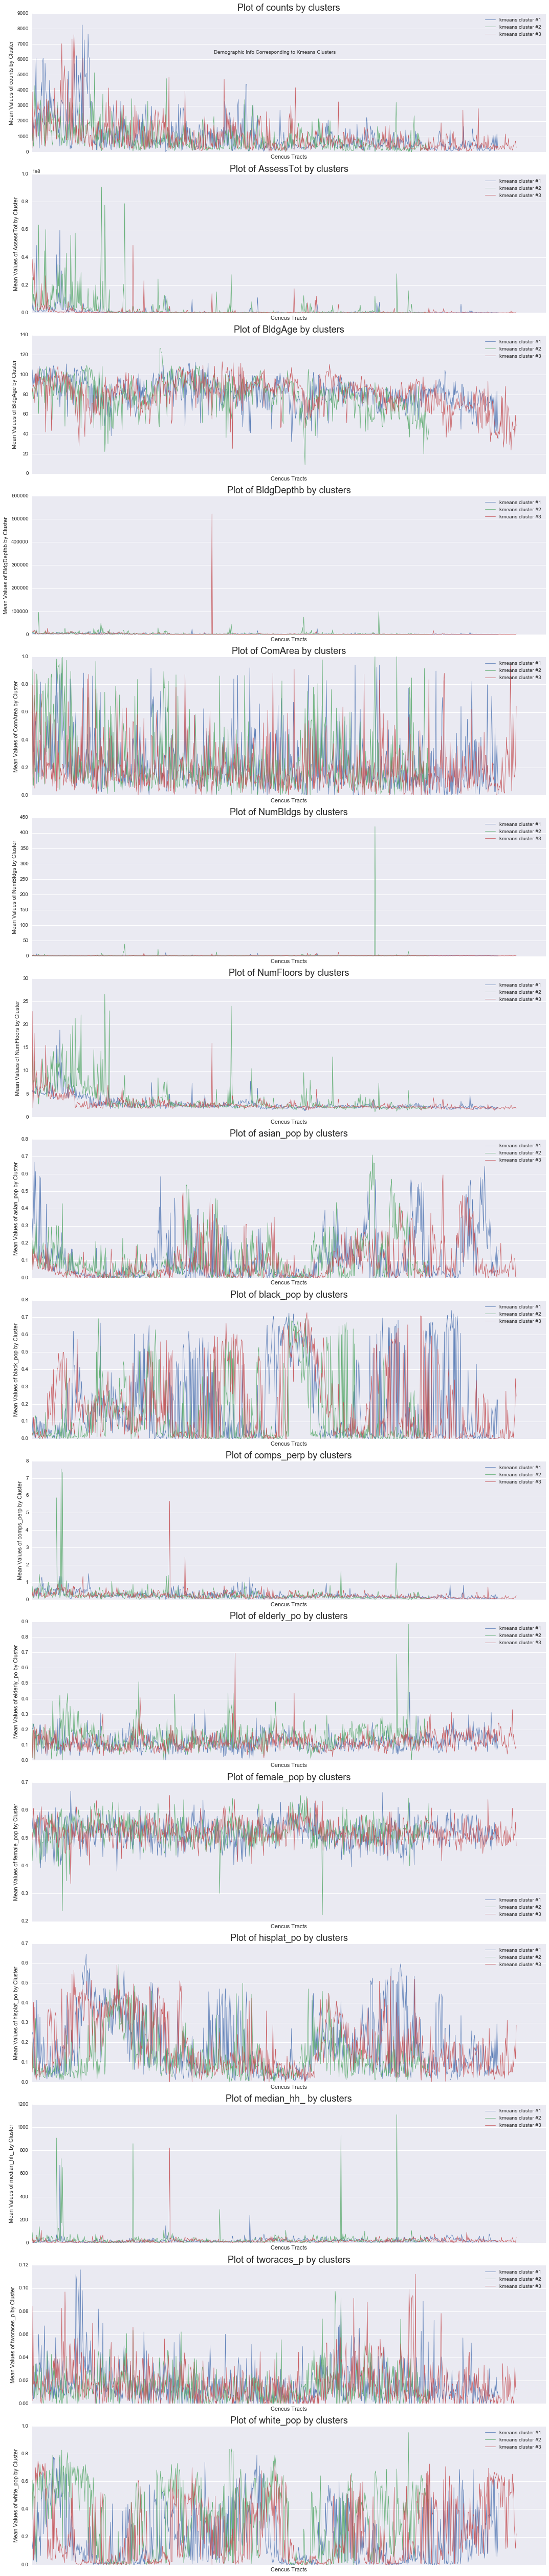

In [132]:
plt.figure(figsize=(15,70))

for i in range(len(info_columns)):
    col = info_columns[i]
    plt.subplot(len(info_columns), 1, i+1)
    
    for j in range(k):  # --# of clusters k=3
        df_col = nyc_clus_info_shape[nyc_clus_info_shape['label_km']==j].groupby('BoroCT2010')[col].mean()
        plt.plot(range(len(df_col)), df_col, label='kmeans cluster #{}'.format(j+1),\
                linewidth=0.8, alpha=1)

    plt.title('Plot of {} by clusters'.format(col), size=18)
    plt.xticks(np.arange(len(df_col), 100.0), np.arange(len(df_col), 100.0), rotation=40)  #df_col.index.values
    plt.xlabel('Cencus Tracts')
    plt.ylabel('Mean Values of {} by Cluster'.format(col))
    plt.legend(loc='best')

plt.suptitle('Demographic Info Corresponding to Kmeans Clusters')
plt.tight_layout()